In [1]:
!pip install gdown
!pip install torchmetrics
!pip install segmentation_models_pytorch
!pip install albumentations
!pip install timm

import numpy as np
import cv2
import matplotlib.pyplot as plt 
import torchmetrics
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.1 MB/s eta 0:00:0000:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=08b7a3e0726f01cb0c693a10ad9aeb736dc52f3154f732aea24efadac5af2e19
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=0de889f82bb42c70184d9326e8adfd28da808044d981ff8e3c32eee63ff876a6
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-py

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std  = std
        
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def accuracy_function(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc/targets_flat.shape[0]

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# https://github.com/albumentations-team/autoalbument/blob/master/examples/pascal_voc/dataset.py
from torchvision.datasets import VOCSegmentation

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)


VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask


trainsize = 256

train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.RGBShift(),
    A.Sharpen(),
    A.CoarseDropout(max_holes=5, max_height=int(384 * 0.1), max_width=int(384 * 0.1)),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])


train_dataset =  PascalVOCSearchDataset(image_set="train", download=True, transform=train_transform)
test_dataset = PascalVOCSearchDataset(image_set="val", download=True, transform=test_transform)

100%|██████████| 1999639040/1999639040 [00:51<00:00, 39032549.00it/s]


Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc
Using downloaded and verified file: /root/data/pascal_voc/VOCtrainval_11-May-2012.tar
Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc


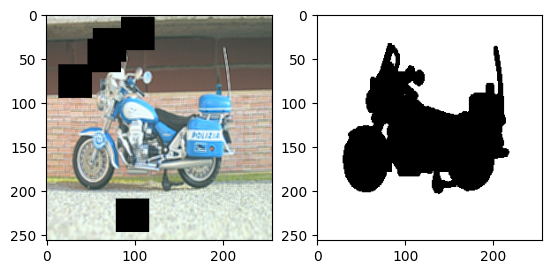

In [3]:
image, mask = train_dataset.__getitem__(800)
plt.subplot(1, 2, 1)
plt.imshow(unorm(image).permute(1, 2, 0)) 
plt.subplot(1, 2, 2)
plt.imshow(mask[:, :, 0], cmap='gray')

plt.show()

In [4]:
#metrics
def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target 

# Feature Attention Network

https://github.com/qubvel-org/segmentation_models.pytorch/blob/main/segmentation_models_pytorch/decoders/pan/

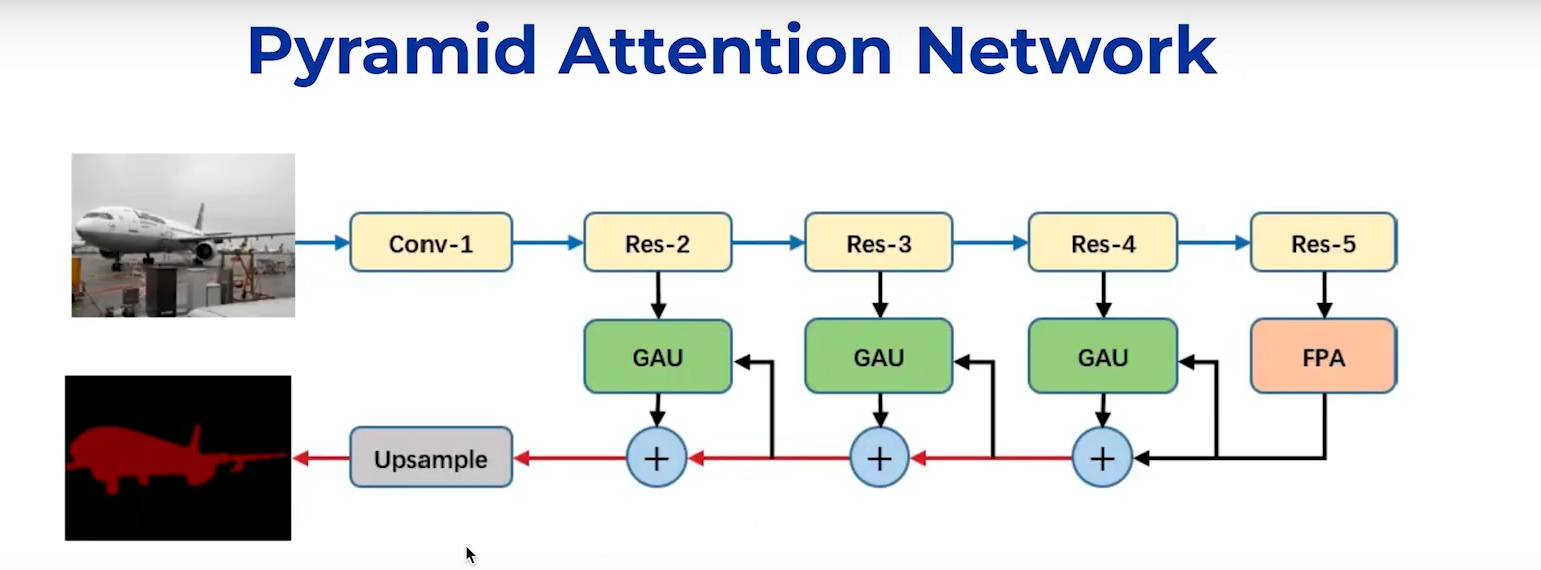
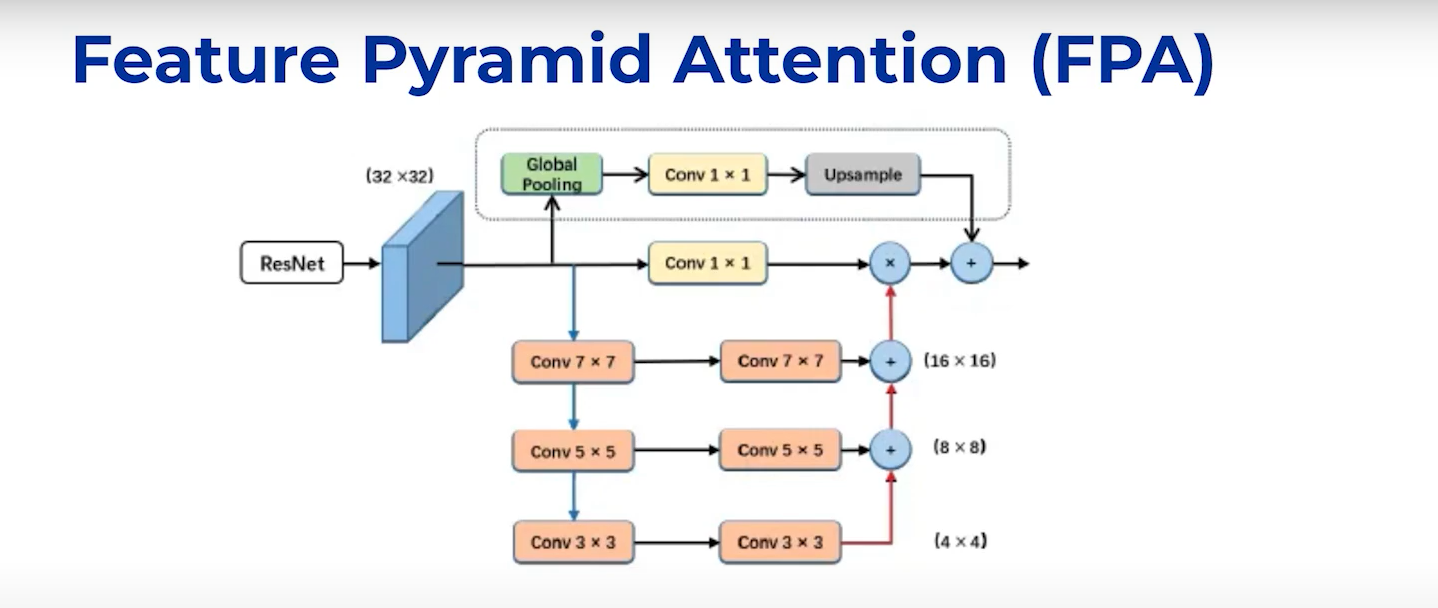
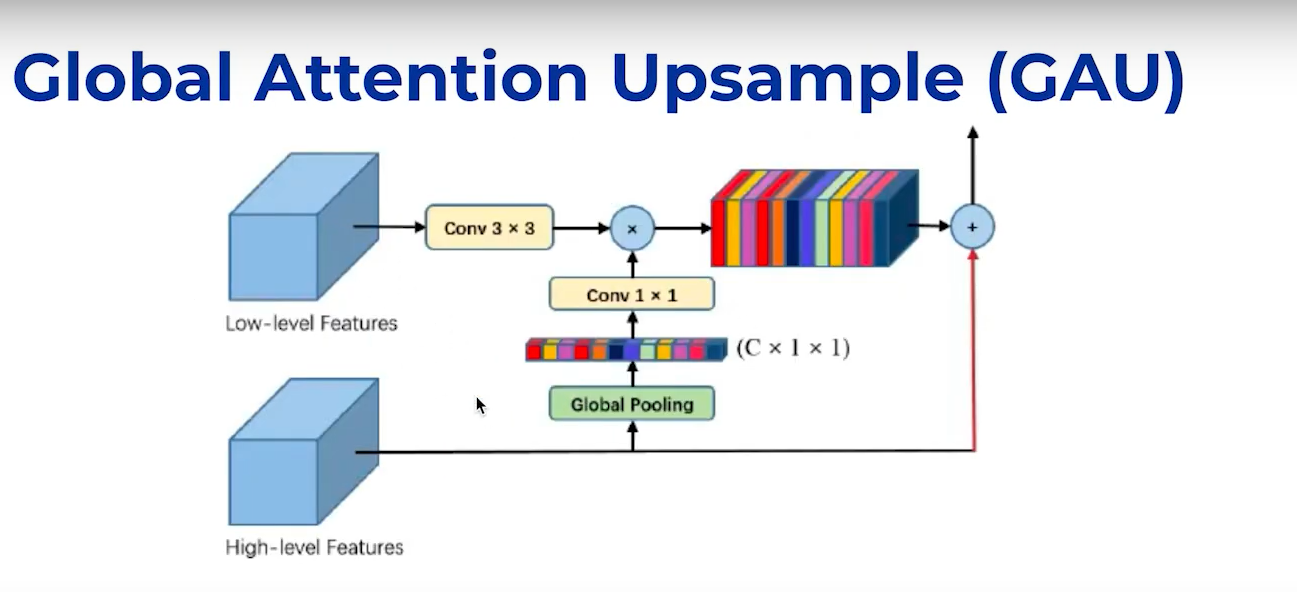
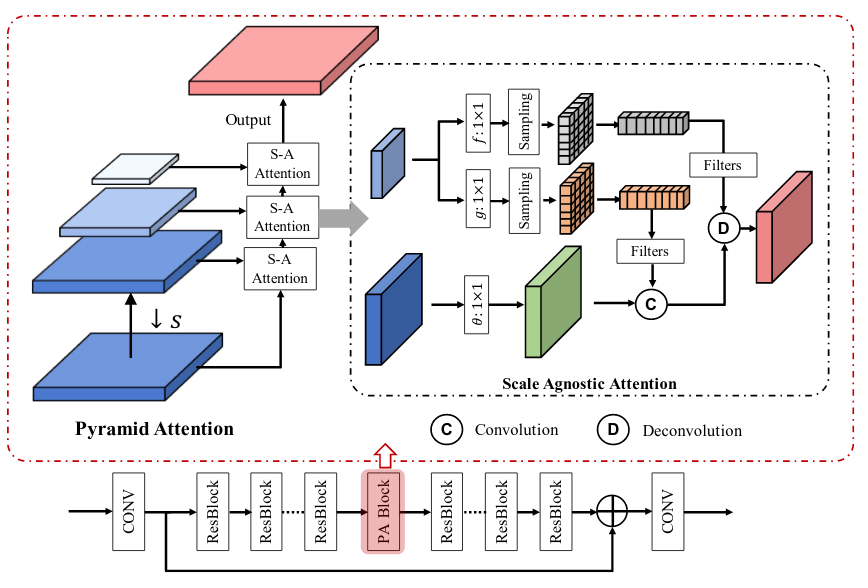
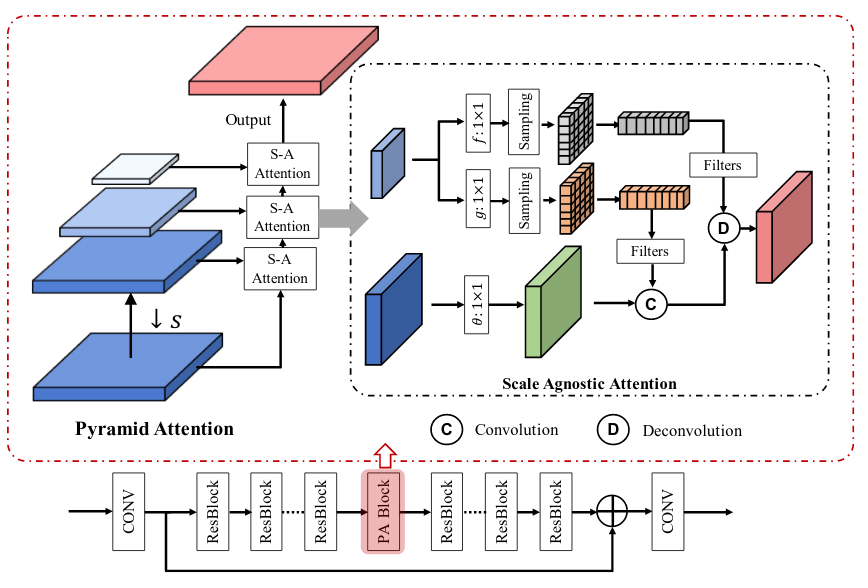

In [5]:
from collections.abc import Sequence
from typing import Literal

import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvBnRelu(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int = 1,
        padding: int = 0,
        dilation: int = 1,
        groups: int = 1,
        bias: bool = True,
        add_relu: bool = True,
        interpolate: bool = False,
    ):
        super(ConvBnRelu, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            bias=bias,
            groups=groups,
        )
        self.add_relu = add_relu
        self.interpolate = interpolate
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.add_relu:
            x = self.activation(x)
        if self.interpolate:
            x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=True)
        return x


class FPABlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, upscale_mode: str = "bilinear"
    ):
        super(FPABlock, self).__init__()

        self.upscale_mode = upscale_mode
        if self.upscale_mode == "bilinear":
            self.align_corners = True
        else:
            self.align_corners = False

        # global pooling branch
        self.branch1 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            ConvBnRelu(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
            ),
        )

        # midddle branch
        self.mid = nn.Sequential(
            ConvBnRelu(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
            )
        )
        self.down1 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBnRelu(
                in_channels=in_channels,
                out_channels=1,
                kernel_size=7,
                stride=1,
                padding=3,
            ),
        )
        self.down2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBnRelu(
                in_channels=1, out_channels=1, kernel_size=5, stride=1, padding=2
            ),
        )
        self.down3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBnRelu(
                in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1
            ),
            ConvBnRelu(
                in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1
            ),
        )
        self.conv2 = ConvBnRelu(
            in_channels=1, out_channels=1, kernel_size=5, stride=1, padding=2
        )
        self.conv1 = ConvBnRelu(
            in_channels=1, out_channels=1, kernel_size=7, stride=1, padding=3
        )

    def forward(self, x):
        h, w = x.size(2), x.size(3)
        b1 = self.branch1(x)
        upscale_parameters = dict(
            mode=self.upscale_mode, align_corners=self.align_corners
        )
        b1 = F.interpolate(b1, size=(h, w), **upscale_parameters)

        mid = self.mid(x)
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x3 = F.interpolate(x3, size=(h // 4, w // 4), **upscale_parameters)

        x2 = self.conv2(x2)
        x = x2 + x3
        x = F.interpolate(x, size=(h // 2, w // 2), **upscale_parameters)

        x1 = self.conv1(x1)
        x = x + x1
        x = F.interpolate(x, size=(h, w), **upscale_parameters)

        x = torch.mul(x, mid)
        x = x + b1
        return x


class GAUBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, upscale_mode: str = "bilinear"
    ):
        super(GAUBlock, self).__init__()

        self.upscale_mode = upscale_mode
        self.align_corners = True if upscale_mode == "bilinear" else None

        self.conv1 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            ConvBnRelu(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=1,
                add_relu=False,
            ),
            nn.Sigmoid(),
        )
        self.conv2 = ConvBnRelu(
            in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1
        )

    def forward(self, x, y):
        """
        Args:
            x: low level feature
            y: high level feature
        """
        h, w = x.size(2), x.size(3)
        y_up = F.interpolate(
            y, size=(h, w), mode=self.upscale_mode, align_corners=self.align_corners
        )
        x = self.conv2(x)
        y = self.conv1(y)
        z = torch.mul(x, y)
        return y_up + z


class PANDecoder(nn.Module):
    def __init__(
        self,
        encoder_channels: Sequence[int],
        encoder_depth: Literal[3, 4, 5],
        decoder_channels: int,
        upscale_mode: str = "bilinear",
    ):
        super().__init__()

        if encoder_depth < 3:
            raise ValueError(
                "Encoder depth for PAN decoder cannot be less than 3, got {}.".format(
                    encoder_depth
                )
            )

        encoder_channels = encoder_channels[2:]

        self.fpa = FPABlock(
            in_channels=encoder_channels[-1], out_channels=decoder_channels
        )

        if encoder_depth == 5:
            self.gau3 = GAUBlock(
                in_channels=encoder_channels[2],
                out_channels=decoder_channels,
                upscale_mode=upscale_mode,
            )
        if encoder_depth >= 4:
            self.gau2 = GAUBlock(
                in_channels=encoder_channels[1],
                out_channels=decoder_channels,
                upscale_mode=upscale_mode,
            )
        if encoder_depth >= 3:
            self.gau1 = GAUBlock(
                in_channels=encoder_channels[0],
                out_channels=decoder_channels,
                upscale_mode=upscale_mode,
            )

    def forward(self, *features):
        features = features[2:]  # remove first and second skip

        out = self.fpa(features[-1])  # 1/16 or 1/32

        if hasattr(self, "gau3"):
            out = self.gau3(features[2], out)  # 1/16
        if hasattr(self, "gau2"):
            out = self.gau2(features[1], out)  # 1/8
        if hasattr(self, "gau1"):
            out = self.gau1(features[0], out)  # 1/4

        return out

In [6]:
from typing import Any, Callable, Literal, Optional, Union

from segmentation_models_pytorch.base import (
    ClassificationHead,
    SegmentationHead,
    SegmentationModel,
)
from segmentation_models_pytorch.encoders import get_encoder


class PAN(SegmentationModel):
    """Implementation of PAN_ (Pyramid Attention Network).

    Note:
        Currently works with shape of input tensor >= [B x C x 128 x 128] for pytorch <= 1.1.0
        and with shape of input tensor >= [B x C x 256 x 256] for pytorch == 1.3.1

    Args:
        encoder_name: Name of the classification model that will be used as an encoder (a.k.a backbone)
            to extract features of different spatial resolution
        encoder_depth: A number of stages used in encoder in range [3, 5]. Each stage generate features
            two times smaller in spatial dimensions than previous one (e.g. for depth 0 we will have features
            with shapes [(N, C, H, W),], for depth 1 - [(N, C, H, W), (N, C, H // 2, W // 2)] and so on).
            Default is 5
        encoder_weights: One of **None** (random initialization), **"imagenet"** (pre-training on ImageNet) and
            other pretrained weights (see table with available weights for each encoder_name)
        encoder_output_stride: 16 or 32, if 16 use dilation in encoder last layer.
            Doesn't work with ***ception***, **vgg***, **densenet*`** backbones.Default is 16.
        decoder_channels: A number of convolution layer filters in decoder blocks
        in_channels: A number of input channels for the model, default is 3 (RGB images)
        classes: A number of classes for output mask (or you can think as a number of channels of output mask)
        activation: An activation function to apply after the final convolution layer.
            Available options are **"sigmoid"**, **"softmax"**, **"logsoftmax"**, **"tanh"**, **"identity"**,
                **callable** and **None**.
            Default is **None**
        upsampling: Final upsampling factor. Default is 4 to preserve input-output spatial shape identity
        aux_params: Dictionary with parameters of the auxiliary output (classification head). Auxiliary output is build
            on top of encoder if **aux_params** is not **None** (default). Supported params:
                - classes (int): A number of classes
                - pooling (str): One of "max", "avg". Default is "avg"
                - dropout (float): Dropout factor in [0, 1)
                - activation (str): An activation function to apply "sigmoid"/"softmax"
                    (could be **None** to return logits)
        kwargs: Arguments passed to the encoder class ``__init__()`` function. Applies only to ``timm`` models. Keys with ``None`` values are pruned before passing.

    Returns:
        ``torch.nn.Module``: **PAN**

    .. _PAN:
        https://arxiv.org/abs/1805.10180

    """

    def __init__(
        self,
        encoder_name: str = "resnet34",
        encoder_depth: Literal[3, 4, 5] = 5,
        encoder_weights: Optional[str] = "imagenet",
        encoder_output_stride: Literal[16, 32] = 16,
        decoder_channels: int = 32,
        in_channels: int = 3,
        classes: int = 1,
        activation: Optional[Union[str, Callable]] = None,
        upsampling: int = 4,
        aux_params: Optional[dict] = None,
        **kwargs: dict[str, Any],
    ):
        super().__init__()

        if encoder_output_stride not in [16, 32]:
            raise ValueError(
                "PAN support output stride 16 or 32, got {}".format(
                    encoder_output_stride
                )
            )

        self.encoder = get_encoder(
            encoder_name,
            in_channels=in_channels,
            depth=encoder_depth,
            weights=encoder_weights,
            output_stride=encoder_output_stride,
            **kwargs,
        )

        self.decoder = PANDecoder(
            encoder_channels=self.encoder.out_channels,
            encoder_depth=encoder_depth,
            decoder_channels=decoder_channels,
        )

        self.segmentation_head = SegmentationHead(
            in_channels=decoder_channels,
            out_channels=classes,
            activation=activation,
            kernel_size=3,
            upsampling=upsampling,
        )

        if aux_params is not None:
            self.classification_head = ClassificationHead(
                in_channels=self.encoder.out_channels[-1], **aux_params
            )
        else:
            self.classification_head = None

        self.name = "pan-{}".format(encoder_name)
        self.initialize()

In [8]:
from segmentation_models_pytorch.encoders import get_encoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


encoder_name = "timm-efficientnet-b4"
encoder_weights = "imagenet"
in_channels = 3
classes = 21

encoder = get_encoder(
    encoder_name,
    in_channels=in_channels,
    weights=encoder_weights,
)

model = PAN(
    encoder_name=encoder_name,
    encoder_weights=encoder_weights,
    in_channels=in_channels,
    classes=classes,
    encoder_depth=5,
    decoder_channels=32,
    activation=None,
).to(device)


In [16]:
# # for n in model.named_modules():
#     if n =="segmentation_head.0.weight":
#         print(n)

In [18]:
# https://www.kaggle.com/code/snnclsr/learning-rate-schedulers/
batch_size = 8
n_workers = 4
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)

# model = smp.create_model("PAN", "timm-efficientnet-b4", "imagenet", 3, 21).to(device)

criterion = nn.CrossEntropyLoss()
# criterion = smp.losses.DiceLoss(mode="multiclass", classes=21) #diceloss = 1-dicescore

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimize, step_size=10, gamma=0.75)
n_eps = 60

train_loss_meter = AverageMeter()
intersection_meter = AverageMeter()
union_meter = AverageMeter()
target_meter = AverageMeter()

num_workers = 4


In [20]:
# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.75)

for ep in range(1, 1 + n_eps):
    train_loss_meter.reset()
    intersection_meter.reset()
    union_meter.reset()
    target_meter.reset()
    model.train()

    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        y = y.argmax(dim=-1)  # Convert (B, 256, 256, 21) -> (B, 256, 256)

        y_hat = model(x)  # (B, C, H, W)
        loss = criterion(y_hat, y)  # (B, C, H, W) >< (B, H, W)
        loss.backward()
        optimizer.step()

        # Save metrics
        with torch.no_grad():
            train_loss_meter.update(loss.item())
            y_hat_mask = y_hat.argmax(dim=1).squeeze(1)  # (B, C, H, W) -> (B, H, W)
            intersection, union, target = intersectionAndUnionGPU(y_hat_mask.float(), y.float(), 21)
            intersection_meter.update(intersection)
            union_meter.update(union)
            target_meter.update(target)

    # Compute iou, dice
    with torch.no_grad():
        iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)  # vector 21D
        dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10)  # vector 21D

        mIoU = torch.mean(iou_class)  # mean vector 21D
        mDice = torch.mean(dice_class)  # mean vector 21D

    # Step the scheduler
    scheduler.step()

    print("EP {}, train loss = {:.4f}, IoU = {:.4f}, dice = {:.4f}, LR = {:.6f}".format(
        ep, train_loss_meter.avg, mIoU, mDice, scheduler.get_last_lr()[0]))

    # Save the model periodically
    if ep >= 58:
        torch.save(model.state_dict(), f"modelFAN__ep_{ep}.pth")


100%|██████████| 183/183 [01:53<00:00,  1.61it/s]


EP 1, train loss = 0.8378, IoU = 0.1346, dice = 0.1974, LR = 0.000100


100%|██████████| 183/183 [01:51<00:00,  1.63it/s]


EP 2, train loss = 0.6898, IoU = 0.2186, dice = 0.3171, LR = 0.000100


100%|██████████| 183/183 [01:50<00:00,  1.66it/s]


EP 3, train loss = 0.5828, IoU = 0.3052, dice = 0.4301, LR = 0.000100


100%|██████████| 183/183 [01:53<00:00,  1.61it/s]


EP 4, train loss = 0.5004, IoU = 0.3943, dice = 0.5388, LR = 0.000100


100%|██████████| 183/183 [01:56<00:00,  1.57it/s]


EP 5, train loss = 0.4540, IoU = 0.4464, dice = 0.5939, LR = 0.000100


100%|██████████| 183/183 [01:55<00:00,  1.58it/s]


EP 6, train loss = 0.4167, IoU = 0.4827, dice = 0.6310, LR = 0.000100


100%|██████████| 183/183 [01:52<00:00,  1.63it/s]


EP 7, train loss = 0.3820, IoU = 0.5173, dice = 0.6635, LR = 0.000100


100%|██████████| 183/183 [01:51<00:00,  1.65it/s]


EP 8, train loss = 0.3569, IoU = 0.5484, dice = 0.6954, LR = 0.000100


100%|██████████| 183/183 [01:51<00:00,  1.64it/s]


EP 9, train loss = 0.3284, IoU = 0.5702, dice = 0.7103, LR = 0.000100


100%|██████████| 183/183 [01:51<00:00,  1.64it/s]


EP 10, train loss = 0.3147, IoU = 0.5914, dice = 0.7305, LR = 0.000075


100%|██████████| 183/183 [01:51<00:00,  1.64it/s]


EP 11, train loss = 0.2993, IoU = 0.6109, dice = 0.7464, LR = 0.000075


100%|██████████| 183/183 [01:50<00:00,  1.65it/s]


EP 12, train loss = 0.2891, IoU = 0.6218, dice = 0.7566, LR = 0.000075


100%|██████████| 183/183 [01:50<00:00,  1.65it/s]


EP 13, train loss = 0.2747, IoU = 0.6338, dice = 0.7673, LR = 0.000075


100%|██████████| 183/183 [01:50<00:00,  1.65it/s]


EP 14, train loss = 0.2543, IoU = 0.6519, dice = 0.7790, LR = 0.000075


100%|██████████| 183/183 [01:50<00:00,  1.65it/s]


EP 15, train loss = 0.2519, IoU = 0.6607, dice = 0.7873, LR = 0.000075


100%|██████████| 183/183 [01:50<00:00,  1.65it/s]


EP 16, train loss = 0.2348, IoU = 0.6812, dice = 0.8026, LR = 0.000075


100%|██████████| 183/183 [01:49<00:00,  1.67it/s]


EP 17, train loss = 0.2362, IoU = 0.6800, dice = 0.8018, LR = 0.000075


100%|██████████| 183/183 [01:51<00:00,  1.64it/s]


EP 18, train loss = 0.2257, IoU = 0.6898, dice = 0.8085, LR = 0.000075


100%|██████████| 183/183 [01:50<00:00,  1.65it/s]


EP 19, train loss = 0.2209, IoU = 0.6952, dice = 0.8131, LR = 0.000075


100%|██████████| 183/183 [01:51<00:00,  1.64it/s]


EP 20, train loss = 0.2216, IoU = 0.6891, dice = 0.8088, LR = 0.000056


100%|██████████| 183/183 [01:52<00:00,  1.63it/s]


EP 21, train loss = 0.2112, IoU = 0.7055, dice = 0.8205, LR = 0.000056


100%|██████████| 183/183 [01:51<00:00,  1.64it/s]


EP 22, train loss = 0.2055, IoU = 0.7104, dice = 0.8227, LR = 0.000056


100%|██████████| 183/183 [01:52<00:00,  1.63it/s]


EP 23, train loss = 0.1965, IoU = 0.7211, dice = 0.8312, LR = 0.000056


100%|██████████| 183/183 [01:50<00:00,  1.65it/s]


EP 24, train loss = 0.1934, IoU = 0.7215, dice = 0.8315, LR = 0.000056


100%|██████████| 183/183 [01:51<00:00,  1.63it/s]


EP 25, train loss = 0.1941, IoU = 0.7211, dice = 0.8320, LR = 0.000056


100%|██████████| 183/183 [01:51<00:00,  1.64it/s]


EP 26, train loss = 0.1902, IoU = 0.7253, dice = 0.8341, LR = 0.000056


100%|██████████| 183/183 [01:50<00:00,  1.65it/s]


EP 27, train loss = 0.1919, IoU = 0.7212, dice = 0.8306, LR = 0.000056


100%|██████████| 183/183 [01:50<00:00,  1.65it/s]


EP 28, train loss = 0.1797, IoU = 0.7363, dice = 0.8419, LR = 0.000056


100%|██████████| 183/183 [01:50<00:00,  1.65it/s]


EP 29, train loss = 0.1779, IoU = 0.7393, dice = 0.8438, LR = 0.000056


100%|██████████| 183/183 [01:51<00:00,  1.64it/s]


EP 30, train loss = 0.1761, IoU = 0.7402, dice = 0.8448, LR = 0.000042


100%|██████████| 183/183 [01:50<00:00,  1.66it/s]


EP 31, train loss = 0.1758, IoU = 0.7429, dice = 0.8473, LR = 0.000042


100%|██████████| 183/183 [01:51<00:00,  1.64it/s]


EP 32, train loss = 0.1729, IoU = 0.7469, dice = 0.8497, LR = 0.000042


100%|██████████| 183/183 [01:49<00:00,  1.66it/s]


EP 33, train loss = 0.1678, IoU = 0.7505, dice = 0.8516, LR = 0.000042


100%|██████████| 183/183 [01:50<00:00,  1.66it/s]


EP 34, train loss = 0.1635, IoU = 0.7571, dice = 0.8563, LR = 0.000042


100%|██████████| 183/183 [01:50<00:00,  1.65it/s]


EP 35, train loss = 0.1622, IoU = 0.7560, dice = 0.8552, LR = 0.000042


100%|██████████| 183/183 [01:50<00:00,  1.65it/s]


EP 36, train loss = 0.1627, IoU = 0.7582, dice = 0.8564, LR = 0.000042


100%|██████████| 183/183 [01:51<00:00,  1.64it/s]


EP 37, train loss = 0.1593, IoU = 0.7608, dice = 0.8586, LR = 0.000042


100%|██████████| 183/183 [01:50<00:00,  1.65it/s]


EP 38, train loss = 0.1594, IoU = 0.7613, dice = 0.8592, LR = 0.000042


100%|██████████| 183/183 [01:50<00:00,  1.65it/s]


EP 39, train loss = 0.1548, IoU = 0.7658, dice = 0.8621, LR = 0.000042


100%|██████████| 183/183 [01:50<00:00,  1.65it/s]


EP 40, train loss = 0.1583, IoU = 0.7646, dice = 0.8613, LR = 0.000032


100%|██████████| 183/183 [01:52<00:00,  1.62it/s]


EP 41, train loss = 0.1535, IoU = 0.7680, dice = 0.8629, LR = 0.000032


100%|██████████| 183/183 [01:53<00:00,  1.61it/s]


EP 42, train loss = 0.1506, IoU = 0.7701, dice = 0.8652, LR = 0.000032


100%|██████████| 183/183 [01:53<00:00,  1.61it/s]


EP 43, train loss = 0.1500, IoU = 0.7713, dice = 0.8658, LR = 0.000032


100%|██████████| 183/183 [01:53<00:00,  1.61it/s]


EP 44, train loss = 0.1471, IoU = 0.7762, dice = 0.8687, LR = 0.000032


100%|██████████| 183/183 [01:52<00:00,  1.62it/s]


EP 45, train loss = 0.1477, IoU = 0.7739, dice = 0.8675, LR = 0.000032


100%|██████████| 183/183 [01:54<00:00,  1.61it/s]


EP 46, train loss = 0.1466, IoU = 0.7758, dice = 0.8687, LR = 0.000032


100%|██████████| 183/183 [01:54<00:00,  1.60it/s]


EP 47, train loss = 0.1424, IoU = 0.7819, dice = 0.8725, LR = 0.000032


100%|██████████| 183/183 [01:54<00:00,  1.60it/s]


EP 48, train loss = 0.1417, IoU = 0.7826, dice = 0.8730, LR = 0.000032


100%|██████████| 183/183 [01:56<00:00,  1.57it/s]


EP 49, train loss = 0.1419, IoU = 0.7825, dice = 0.8726, LR = 0.000032


100%|██████████| 183/183 [01:54<00:00,  1.61it/s]


EP 50, train loss = 0.1419, IoU = 0.7817, dice = 0.8727, LR = 0.000024


100%|██████████| 183/183 [01:54<00:00,  1.60it/s]


EP 51, train loss = 0.1395, IoU = 0.7824, dice = 0.8727, LR = 0.000024


100%|██████████| 183/183 [01:55<00:00,  1.58it/s]


EP 52, train loss = 0.1404, IoU = 0.7834, dice = 0.8737, LR = 0.000024


100%|██████████| 183/183 [01:55<00:00,  1.59it/s]


EP 53, train loss = 0.1379, IoU = 0.7879, dice = 0.8769, LR = 0.000024


100%|██████████| 183/183 [01:53<00:00,  1.61it/s]


EP 54, train loss = 0.1409, IoU = 0.7839, dice = 0.8741, LR = 0.000024


100%|██████████| 183/183 [01:53<00:00,  1.61it/s]


EP 55, train loss = 0.1382, IoU = 0.7862, dice = 0.8757, LR = 0.000024


100%|██████████| 183/183 [01:52<00:00,  1.63it/s]


EP 56, train loss = 0.1334, IoU = 0.7919, dice = 0.8793, LR = 0.000024


100%|██████████| 183/183 [01:55<00:00,  1.59it/s]


EP 57, train loss = 0.1356, IoU = 0.7907, dice = 0.8787, LR = 0.000024


100%|██████████| 183/183 [01:53<00:00,  1.61it/s]


EP 58, train loss = 0.1338, IoU = 0.7913, dice = 0.8783, LR = 0.000024


100%|██████████| 183/183 [01:55<00:00,  1.59it/s]


EP 59, train loss = 0.1333, IoU = 0.7925, dice = 0.8796, LR = 0.000024


100%|██████████| 183/183 [01:53<00:00,  1.61it/s]


EP 60, train loss = 0.1346, IoU = 0.7897, dice = 0.8781, LR = 0.000018


In [21]:
model.eval()
test_intersection_meter = AverageMeter()
test_union_meter = AverageMeter()
test_target_meter = AverageMeter()
with torch.no_grad():
    for batch_id, (x, y) in enumerate(tqdm(testloader), start=1):
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        y = y.argmax(dim=-1)  # Convert (B, 256, 256, 21) -> (B, 256, 256)

        y_hat = model(x)
        y_hat = y_hat.squeeze(1)
        y_hat_mask = y_hat.argmax(dim=1)
        
        intersection, union, target = intersectionAndUnionGPU(y_hat_mask, y, 21)
        test_intersection_meter.update(intersection)
        test_union_meter.update(union)
        test_target_meter.update(target)
        
    iou_class = test_intersection_meter.sum / (test_union_meter.sum + 1e-10)
    dice_class = 2*test_intersection_meter.sum / (test_intersection_meter.sum + test_union_meter.sum + 1e-10)

    mIoU = torch.mean(iou_class)
    mDice = torch.mean(dice_class)
        
print("TEST: IoU = {}, dice = {}".format(mIoU, mDice))

100%|██████████| 182/182 [01:44<00:00,  1.75it/s]

TEST: IoU = 0.5535054802894592, dice = 0.6920750737190247


background
person
sofa
tv/monitor


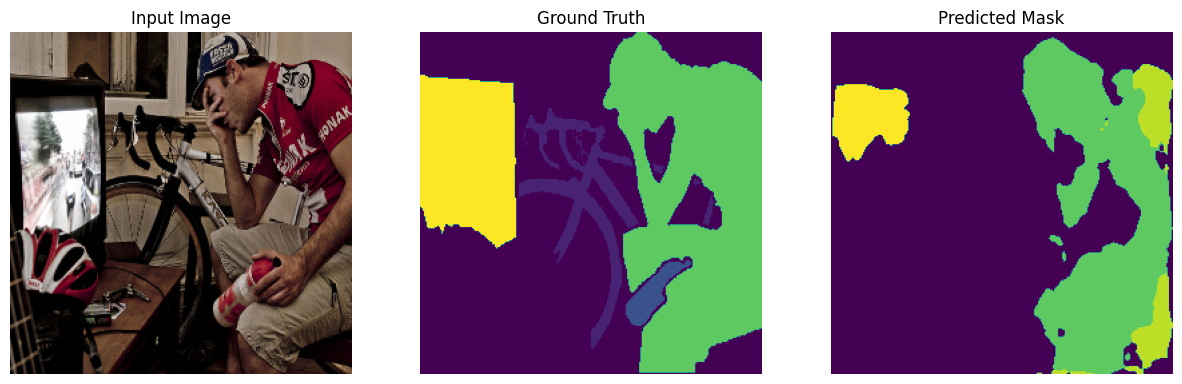

background
chair
diningtable


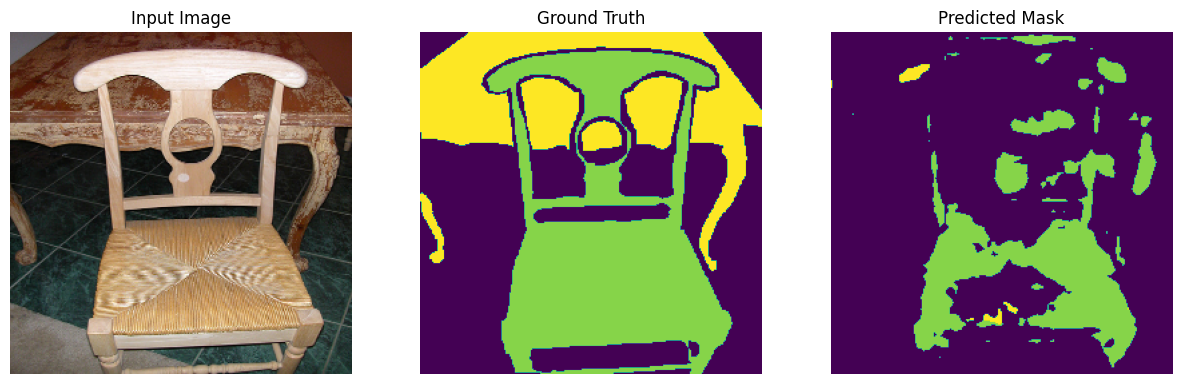

background
horse
person


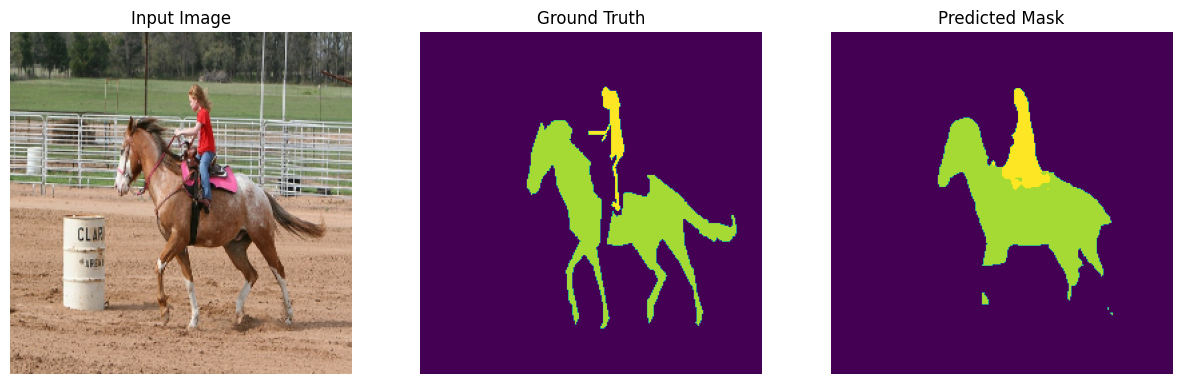

background
cat
dog


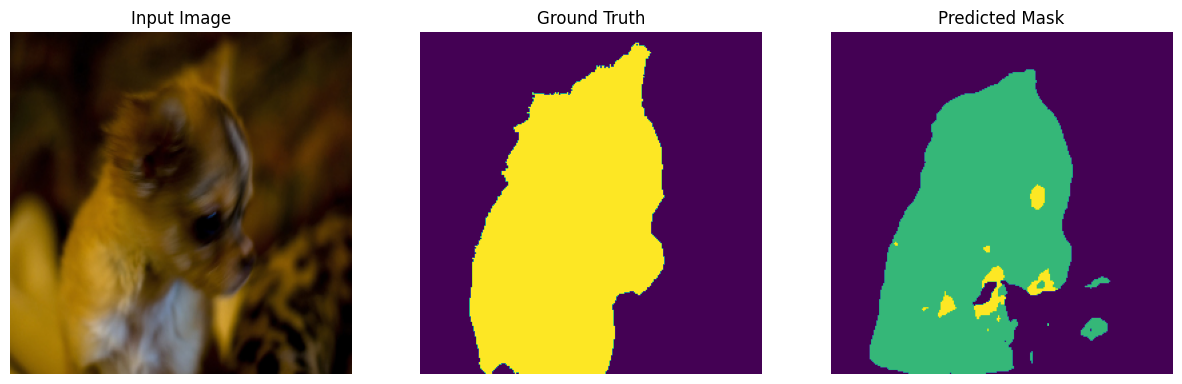

background
bus
person


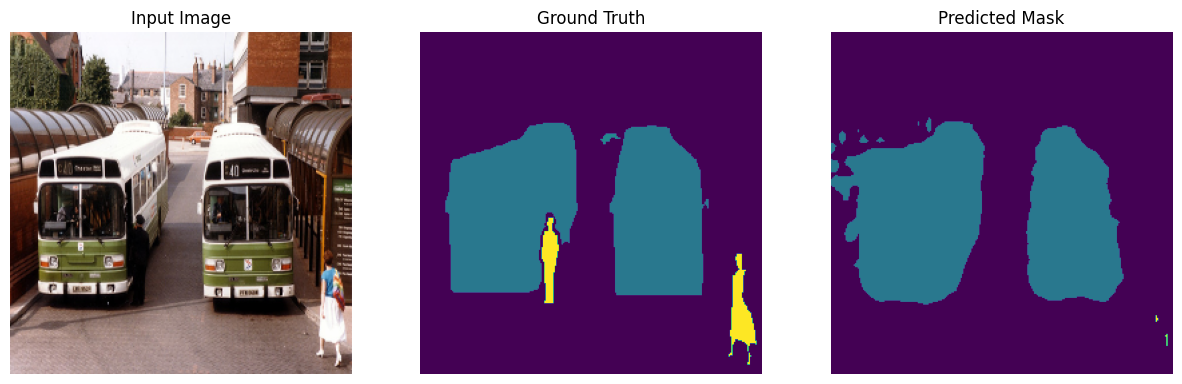

background
aeroplane


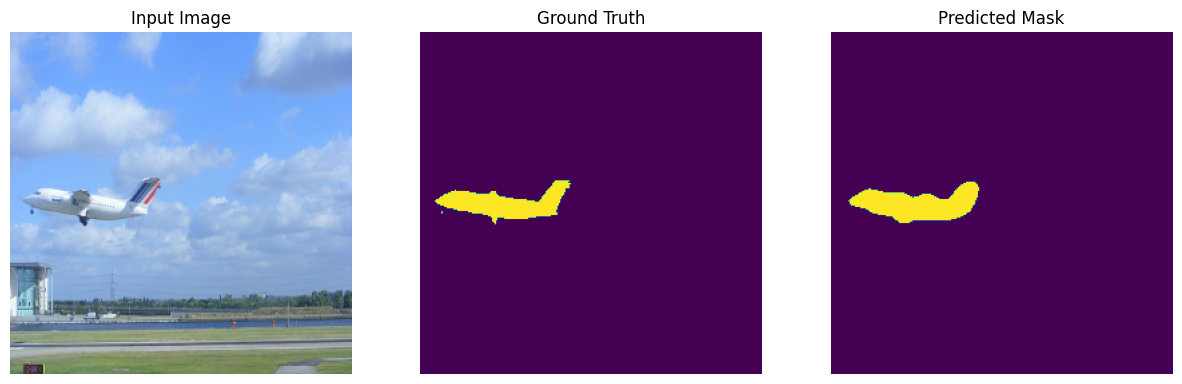

background
bird


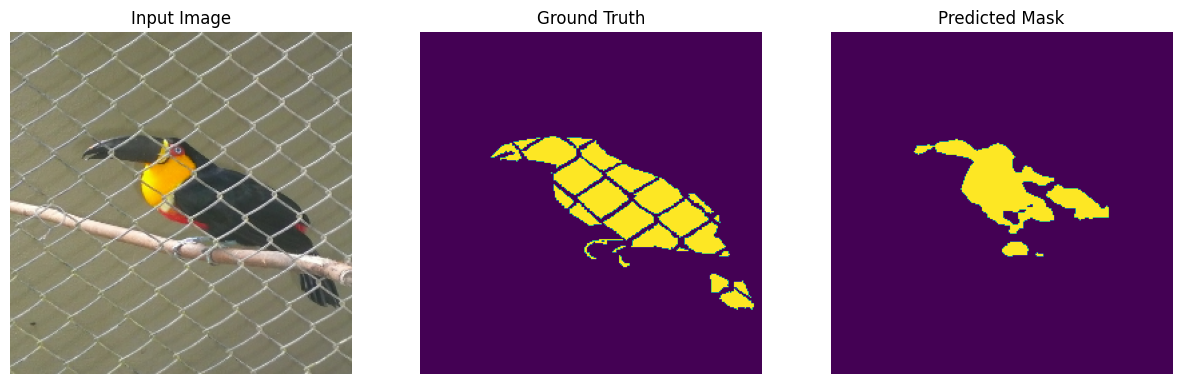

background
car


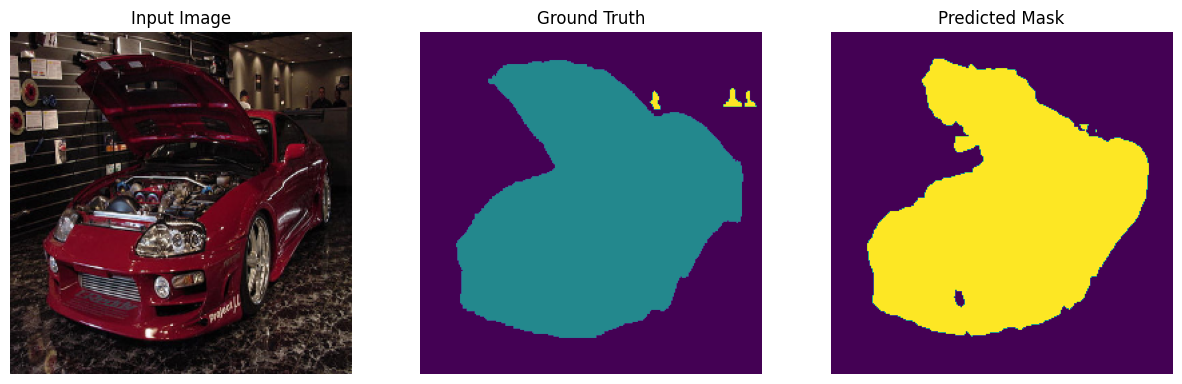

background
cat
dog


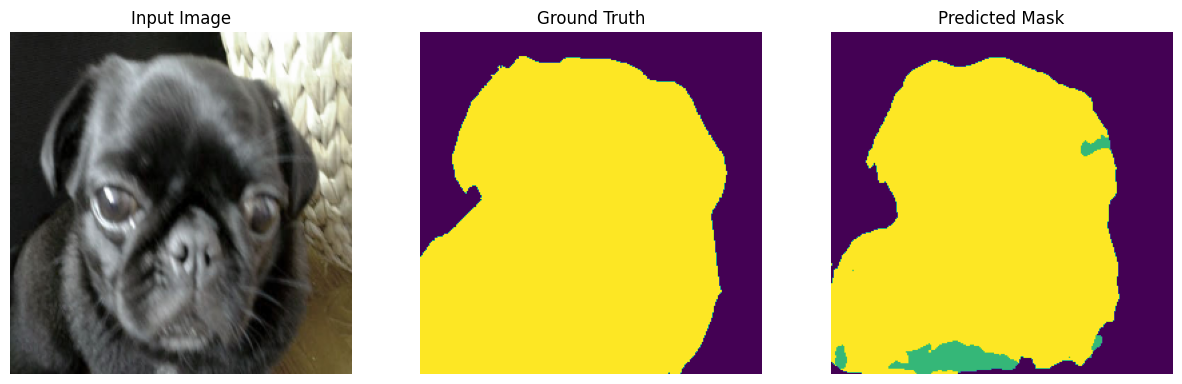

background
cat
dog
sheep


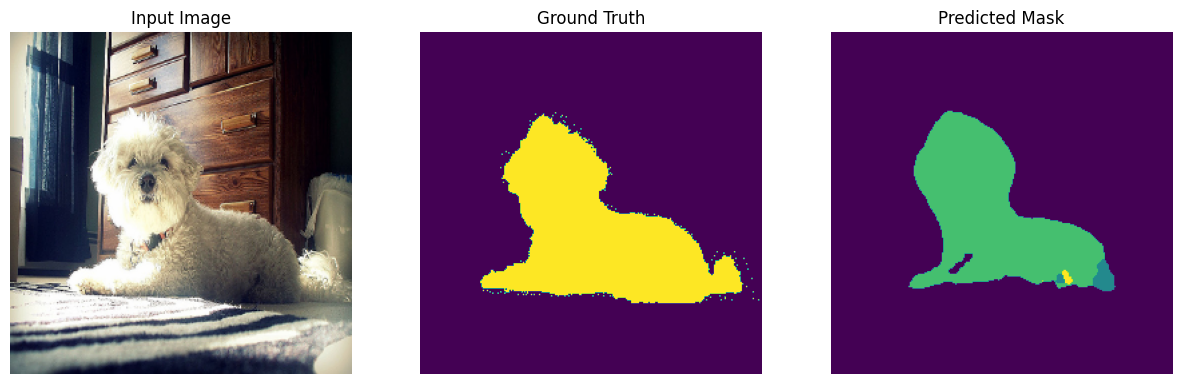

background
car


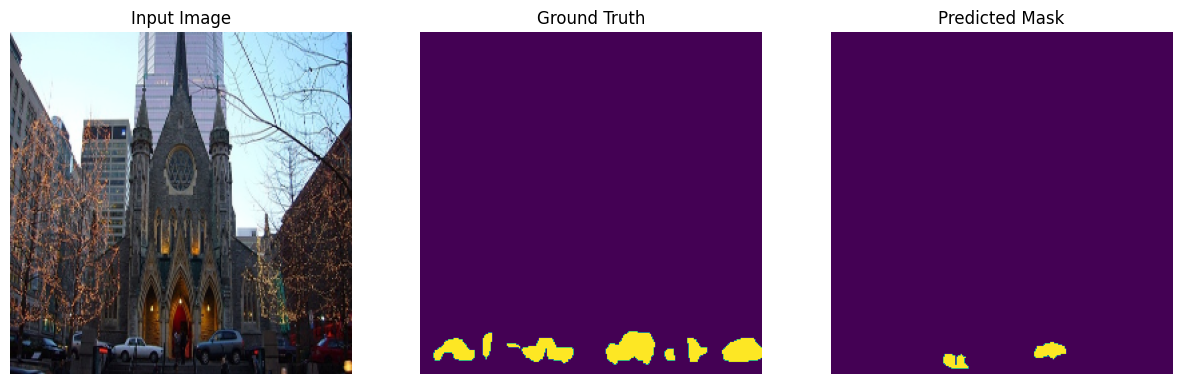

background
chair
diningtable


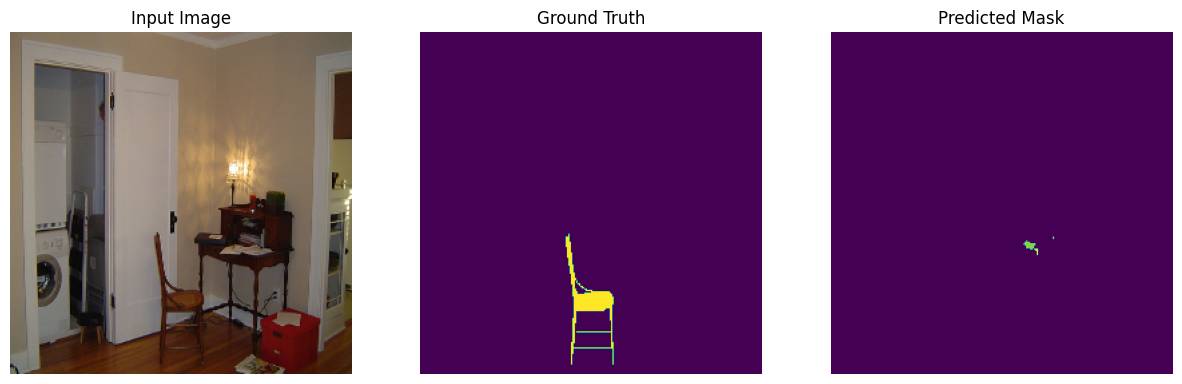

background
car
dog
person


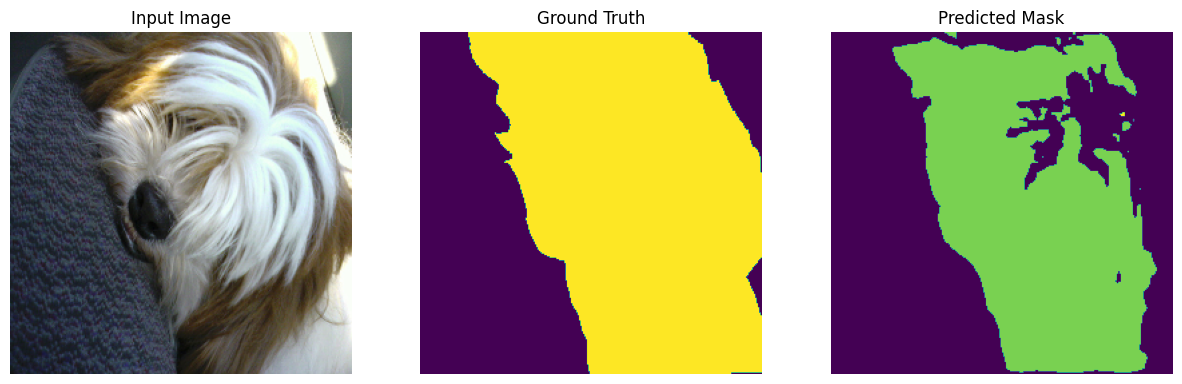

background
cat


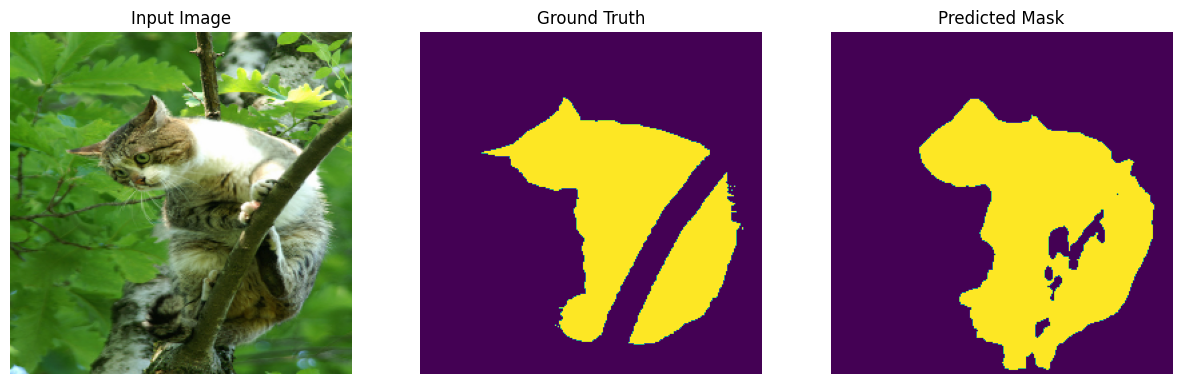

background
motorbike


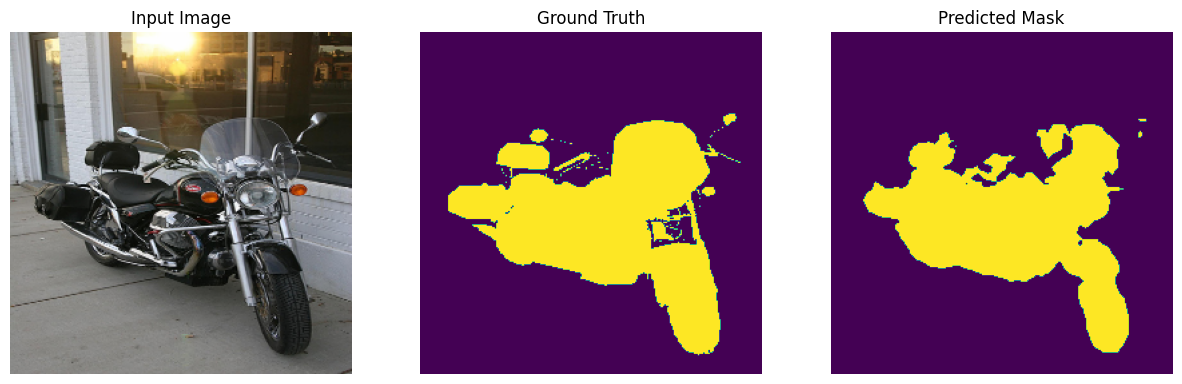

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

for i in range(15):
    # Randomly select an image and its ground truth from the test dataset
    id = random.randint(0, len(test_dataset) - 1)
    
    with torch.no_grad():
        model.eval()
        x, y = test_dataset.__getitem__(id)
        x = x.unsqueeze(0).to(device)  # Add batch dimension
        y_predict = model(x).argmax(dim=1).squeeze().cpu().numpy()  # Get predicted mask (2D array)
        
        # Print class labels for the predicted mask (if any)
        for class_id in np.unique(y_predict):
            print(VOC_CLASSES[class_id])

    # Convert the input image to a numpy array for visualization (if it's a tensor)
    x = x.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to (H, W, C) for RGB
    
    # Convert ground truth (if y is one-hot encoded, apply argmax to get the class labels)
    ground_truth = y.squeeze().cpu().numpy()  # (H, W, 21) -> (H, W)
    ground_truth = np.argmax(ground_truth, axis=-1)  # Apply argmax to reduce to (H, W)
    
    # Define the mean and std values used for normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Unnormalize: multiply by std and add mean for each channel
    unnormalized_image = x * std + mean  # Unnormalize the image

    # Clip values to [0, 1] to make sure they are within the valid range for displaying
    unnormalized_image = np.clip(unnormalized_image, 0, 1)
    
    # Plot the input image, ground truth, and predicted mask
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Input Image (unnormalized)
    axes[0].imshow(unnormalized_image)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    # Ground Truth (2D array with class labels)
    axes[1].imshow(ground_truth)
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")
    
    # Predicted Mask (2D array with class labels)
    axes[2].imshow(y_predict)
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()